<a href="https://colab.research.google.com/github/ThatManRong/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning

In [2]:
import pytorch_lightning as pl
pl.seed_everything(1234)
from torch import nn
import torch

Global seed set to 1234


#Math Derivation

Reference: 

VAE Loss (ELBO): $min \mathbb{E}_q[log q(z\mid x)-logp(z)]-\mathbb{E}_qlogp(x\mid z)$

where 

*   $\mathbb{E}_q[log q(z\mid x)-logp(z)]$ is the KL-divergence
*   $\mathbb{E}_qlogp(x\mid z)$ is the reconstruction. 

**Derivation**: we have a distribution over inputs, p(x). Multiple time series in this case. 

Assume we have factors that influence x, but not observable. z:= latent variables. So marginal distribution is: $p(x) = \int_z p(x\mid z) dz$, by law of total probability in continuous time. So the joint distribution can be seen as: 

$p(x,z) = p(z \mid x) p(x)$

Goal is to find the $p(x)$ term. So we define $q(z\mid x)$ to approximate $p(z \mid x)$, $q$ is called the **approximate posterior** and $p$ is called the **true posterior**. 

Now treat this as an optimization problem in ML, where we have a source (p) and a target (q), and we parametrize q with a neural net to try to get close to p via gradient descent. And this distance to minimize is called the **KL divergence**. 

So the KL divergence between two distribution P, Q is: 

$D_{KL}(Q \mid\mid P) = \sum Qlog(\frac{Q}{P}) = \sum q(z\mid x)log(\frac{q(z\mid x)}{p(z\mid x)})$

Further derive this, we have:


\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
\end{align}


The first term is DL Divergence we want to minimize, the second term is the variational lower bound (ELBO) that we want to maximize. 

To maximize the ELBO, we can minimize the negative of the ELBO (which will be our objective in neural net)

$$
\max \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} =
\min  - [\mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}]
$$

This is consistent with the first line: 

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

#Implementation

In [ ]:
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts


Use resnet here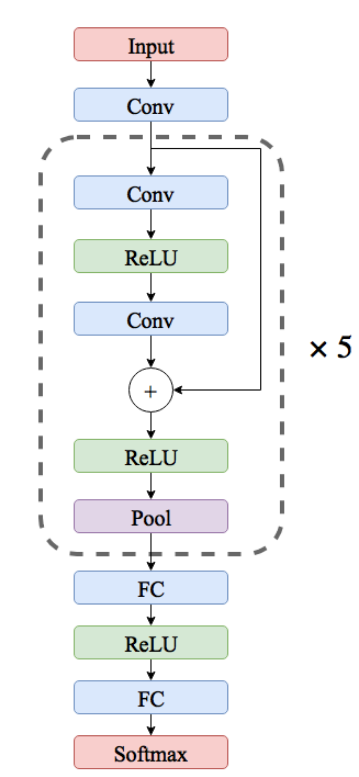

In [4]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

/usr/local/lib/python3.7/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [5]:
vae = VAE()

Sample Z 

(note that $q(z\mid x)$ is assumed to be a neural network. It does not generate z, but it generates parameters for a distribution over z)

      Time         X         Y    Spread
0        0  1.002408  1.003466 -0.001058
1        1  0.997379  0.997428 -0.000049
2        2  1.001412  1.001256  0.000156
3        3  0.993837  0.993936 -0.000099
4        4  0.996272  0.996872 -0.000600
...    ...       ...       ...       ...
1019  1019  1.003976  1.002826  0.001150
1020  1020  1.003738  1.003029  0.000710
1021  1021  0.999012  1.000086 -0.001075
1022  1022  1.001442  1.001717 -0.000275
1023  1023  0.999607  0.999296  0.000311

[1024 rows x 4 columns]


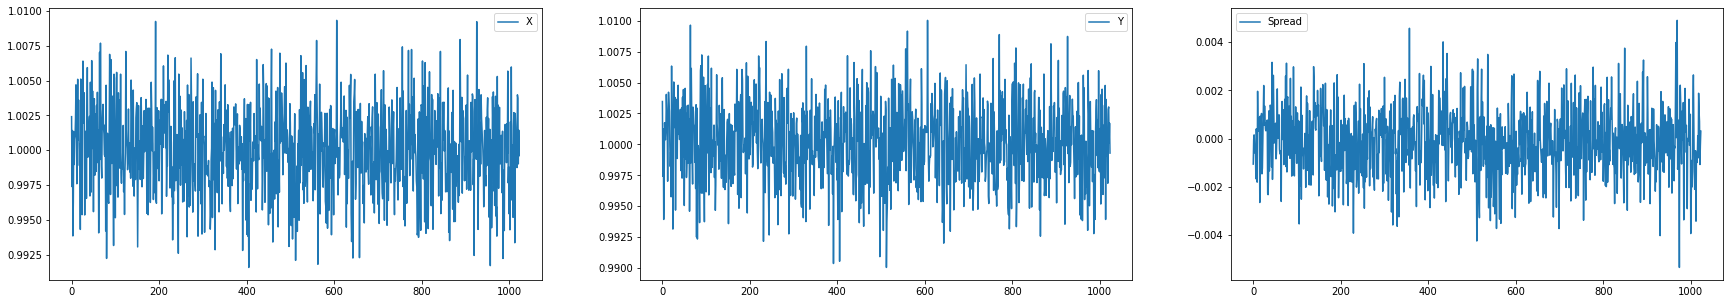

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint
import random

def generate_cointegrated_ts():
  p_value = 1
  while p_value > 0.3:
    # Generate correlated time series.
    # 1. Simulate correlated random variables by Cholesky Decomposition.
    corr = np.array([[1.0, 0.9],
                    [0.9, 1.0]])
    L = scipy.linalg.cholesky(corr)
    dim = 1024
    rnd = np.random.normal(0, 1, size=(dim, 2))
    out = rnd @ L

    # 2. Simulate GBM returns and prices.
    dt = 1/252
    base1 = 110; mu1 = 0.01; sigma1 = 0.05
    base2 = 80;  mu2 = 0.03; sigma2 = 0.05
    ret1  = np.exp((mu1 - 0.5 * (sigma1 ** 2) ) * dt + sigma1 * out[:, 0] * np.sqrt(dt))
    ret2  = np.exp((mu2 - 0.5 * (sigma2 ** 2) ) * dt + sigma2 * out[:, 1] * np.sqrt(dt))

    price1 = base1 * np.cumprod(ret1)
    price2 = base2 * np.cumprod(ret2)

    # 3. Calculate the return correlation and the p-value for cointegration testing.
    corr_ret , _   = scipy.stats.pearsonr(ret1, ret2)
    corr_price , _ = scipy.stats.pearsonr(price1, price2)
    _, p_value, _  = coint(price1, price2)
  data = {'Time': [i for i in range(dim)], 
        'X': ret1,
        'Y': ret2,
        'Spread': ret1-ret2}
  
# Convert the dictionary into DataFrame 
  data = pd.DataFrame(data) 
  return data
data = generate_cointegrated_ts()
print(data)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.plot(data["X"])
plt.legend(["X"])
plt.subplot(1,3,2)
plt.plot(data["Y"])
plt.legend(["Y"])
plt.subplot(1,3,3)
plt.plot(data["Spread"])
plt.legend(["Spread"])

In [7]:
vae = VAE()


In [8]:
targets_df = pd.DataFrame(data=data[["X","Y","Spread"]])
targets_df.columns = ['X','Y','Spread']
x = torch.Tensor(targets_df.values)
#x = torch_tensor.type(double)
x = torch.reshape(x, (1,3,32,32))
# x = torch.rand(1,3,32,32)
print('image shape:', x.shape)
#Get Q(z | x) parameters
#Encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
print('mu:', mu.shape)
print('log_var:', log_var.shape)


# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


Decoding Step

Take input $z$ and generate parameters for a distribution, from which to sample a reconstruction. 

This defines $logp(x\mid z)$, the first term of KL divergence. 

In [9]:
x_hat = vae.decoder(z)
print("parameters for the distribution", x_hat.shape)

parameters for the distribution torch.Size([1, 3, 32, 32])


In [10]:
#Compute the reconstruction loss
recon_loss = F.mse_loss(x_hat, x, reduction = 'none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print("Wrong Reconstruction Loss", recon_loss)

Wrong Reconstruction Loss tensor([3954.2612], grad_fn=<SumBackward1>)


In [11]:
#Compute the probability of x under this n-dimensional distribution: 
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale) #Use normal ?? or something else. 
log_pxz = dist.log_prob(x)
print(log_pxz.shape)
# sum across channels, and all units
# this gives the log probability of THIS particular input dataframe
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

torch.Size([1, 3, 32, 32])
torch.Size([1])
reconstruction loss: -4800.109375


Second Term in KL Divergence

Here, we want to compute $\mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}$

Kind of hard to compute analytically, so use monte carlo simulation

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

This means that we need to compute p(z) and q(z|x) by sampling. 

In [12]:
# 1. define the first two probabilities (Use normal?? )
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))  #N(0,1)
q = torch.distributions.Normal(mu, std) #N(mu, sigma)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

torch.Size([1, 256]) torch.Size([1, 256])
tensor([56.7639], grad_fn=<SumBackward1>)


ELBO

In [13]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(56.7639, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(-4800.1094, grad_fn=<MeanBackward0>)
elbo:  tensor(4856.8730, grad_fn=<MeanBackward0>)


#Full Implementation for training

In [26]:
import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [27]:
pl.seed_everything(1234)
targets_df = pd.DataFrame(data=data[["X","Y","Spread"]])
targets_df.columns = ['X','Y','Spread']
x = torch.Tensor(targets_df.values)
#x = torch_tensor.type(double)
x = torch.reshape(x, (1,3,32,32))

batch_size = 128
train_data = torch.utils.data.DataLoader(x,1)
vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=10)
trainer.fit(vae, train_data)

Global seed set to 1234
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


1

In [58]:
from matplotlib.pyplot import imshow, figure

num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))
figure(figsize=(8, 3), dpi=300)
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# PLOT IMAGES
pred = pred.numpy()
x = np.reshape(pred[1], (1024,3))
px = pd.DataFrame(x)
#px.columns = ['X','Y','Spread']

print(px.transpose())

       0         1         2     ...      1021      1022      1023
0  0.623437  0.922532  1.019619  ...  0.887642  0.434832  0.505151
1  0.981449  1.174990  1.070056  ...  0.647087  1.130675  0.586355
2  0.845455  1.224742  0.716548  ...  0.512456  1.098408  0.195967

[3 rows x 1024 columns]


<Figure size 2400x900 with 0 Axes>

In [67]:
x = np.reshape(pred[10], (3,1024))
print(x)
#plt.plot(x)
print(x[0].shape)

_, p_value_x, _ = coint(x[0], data["X"])
print(p_value_x)
_, p_value_y, _ = coint(x[1], data["Y"])
print(p_value_y)
_, p_value_spread, _ = coint(x[2], data["Spread"])
print(p_value_spread)

[[0.61418164 0.78021604 0.8015942  ... 0.38331422 0.74789214 0.7989745 ]
 [0.17701855 0.36313182 0.5009872  ... 1.2079672  1.0906674  1.1678762 ]
 [0.11058696 0.55994517 0.4616449  ... 1.1447732  0.5413651  0.77965784]]
(1024,)
0.0006745115735228095
8.776389996721432e-29
4.8440579435503694e-27
